In [ ]:
# Import necessary libraries
import os
import random
import cv2
import numpy as np
from PIL import Image
from google.colab import drive

# Mount Google Drive to access the data
drive.mount('/content/drive')

# Define function to rotate, flip, and adjust brightness and contrast
def augment_image(image_path, num_augmentations, contrast_factor):
    # Open the image
    with Image.open(image_path) as img:
        # Crop the image to a square
        width, height = img.size
        size = min(width, height)
        left = (width - size) // 2
        top = (height - size) // 2
        right = (width + size) // 2
        bottom = (height + size) // 2
        cropped_img = img.crop((left, top, right, bottom))

        # Loop through the number of augmentations
        for i in range(num_augmentations):
            # Rotate the image by a random angle between -30 and 30 degrees
            angle = random.randint(-30, 30)
            rotated_img = cropped_img.rotate(angle)

            # Flip the image horizontally with 50% probability
            if random.random() < 0.5:
                rotated_img = rotated_img.transpose(method=Image.FLIP_LEFT_RIGHT)

            # Convert the PIL image to OpenCV format
            cv2_img = cv2.cvtColor(np.array(rotated_img), cv2.COLOR_RGB2BGR)

            # Apply the brightness and contrast adjustments
            contrasted_img = cv2.addWeighted(cv2_img, contrast_factor, cv2_img, 0, 0)
            # Save the augmented image with a new filename
            new_filename = os.path.splitext(image_path)[0] + f"_aug{i+1}.jpg"
            cv2.imwrite(new_filename, cv2_img)

            # Apply the brightness and contrast adjustments
            contrasted_img = cv2.addWeighted(cv2_img, contrast_factor, cv2_img, 0, 0)

            # Save the contrasted version of the augmented image with a new filename
            contrasted_filename = os.path.splitext(image_path)[0] + f"_aug{i+1}_contrasted.jpg"
            cv2.imwrite(contrasted_filename, contrasted_img)

    # Delete the original image after augmentation
    os.remove(image_path)

# Define the main directory where the dataset is located
main_dir = '/content/drive/MyDrive/Data/'

# Define the brightness and contrast factors
contrast_factor = 1.35
all = 0
# Loop over each subdirectory in the main directory
for subdir in os.listdir(main_dir):
    print(subdir)
    t = 0
    subdir_path = os.path.join(main_dir, subdir)
    if os.path.isdir(subdir_path):
        # Loop over each image file in the subdirectory
        for filename in os.listdir(subdir_path):
            t+=1
            img_path = os.path.join(subdir_path, filename)
            if os.path.isfile(img_path) and (filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg')):
                # Augment the image and save the augmented images in the same directory
                augment_image(img_path, 30, contrast_factor)
    all+=t
    print(subdir, t)
print(all)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
2100
2100 5
800
800 7
2700 (1)
2700 (1) 3
1400 (1)
1400 (1) 5
1200 (1)
1200 (1) 3
1100 (1)
1100 (1) 15
900 (1)
900 (1) 10
850 (1)
850 (1) 9
700 (1)
700 (1) 5
500 (1)
500 (1) 4
66


In [ ]:
import os
import numpy as np
import cv2
from google.colab import drive
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc, f1_score
import itertools
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/gdrive')

# Set dataset directory
dataset_dir = "/content/gdrive/MyDrive/Main"

# Set image size
img_size = 128

# Define batch size
batch_size = 16

# Load images and labels
images = []
labels = []
class_names = os.listdir(dataset_dir)
num_classes = len(class_names)
all = 0
for i, class_name in enumerate(class_names):
    t = 0
    print("Processing class {} ({}/{})".format(class_name, i+1, num_classes))
    class_dir = os.path.join(dataset_dir, class_name)
    for file_name in os.listdir(class_dir):
        t += 1
        all += 1
        img_path = os.path.join(class_dir, file_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (img_size, img_size))
        images.append(img)
        labels.append(i)
    print(class_name, t)
print(all)

# Convert to numpy arrays
images = np.array(images, dtype="float32")
labels = np.array(labels)

# Normalize pixel values to [0, 1]
images /= 255

# Convert labels to one-hot encoded vectors
labels = to_categorical(labels, num_classes=num_classes)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=42)

# Define the AlexNet model architecture with added BatchNormalization layers and increased dropout
model = Sequential()
model.add(Conv2D(96, (7, 7), strides=(2, 2), activation='relu', input_shape=(img_size, img_size, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Conv2D(256, (5, 5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Conv2D(384, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(384, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Flatten())
model.add(Dense(2048, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.6))
model.add(Dense(2048, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.6))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Create an instance of ImageDataGenerator with additional augmentations
data_gen = ImageDataGenerator(width_shift_range=0.2,
                              height_shift_range=0.2,
                              fill_mode='nearest')

# Calculate the number of steps per epoch
steps_per_epoch = len(X_train) // batch_size

# Define early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# Train the model using data augmentation and batch loading
model.fit(data_gen.flow(X_train, y_train, batch_size=batch_size), steps_per_epoch=steps_per_epoch, validation_data=(X_test, y_test), epochs=20, callbacks=[early_stopping, reduce_lr])

# Evaluate the model
_, accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Test accuracy: {:.2f}%".format(accuracy * 100))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Processing class 2100 (1/10)
2100 300
Processing class 800 (2/10)
800 420
Processing class 2700 (1) (3/10)
2700 (1) 180
Processing class 1400 (1) (4/10)
1400 (1) 300
Processing class 1200 (1) (5/10)
1200 (1) 180
Processing class 1100 (1) (6/10)
1100 (1) 900
Processing class 900 (1) (7/10)
900 (1) 600
Processing class 850 (1) (8/10)
850 (1) 540
Processing class 700 (1) (9/10)
700 (1) 300
Processing class 500 (1) (10/10)
500 (1) 240
3960
Epoch 1/20
198/198 [==============================] - 22s 82ms/step - loss: 9.0545 - accuracy: 0.2172 - val_loss: 11.1722 - val_accuracy: 0.2273 - lr: 1.0000e-04
Epoch 2/20
198/198 [==============================] - 15s 73ms/step - loss: 6.8599 - accuracy: 0.3636 - val_loss: 14.9530 - val_accuracy: 0.2273 - lr: 1.0000e-04
Epoch 3/20
198/198 [==============================] - 15s 73ms/step - loss: 6.2078 - accuracy: 0.4848 - v

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

25/25 [==============================] - 0s 12ms/step


In [ ]:
# Get integer labels from one-hot encoded labels
y_true_int = np.argmax(y_test, axis=1)
y_pred_int = np.argmax(y_pred, axis=1)

# Map integer labels to class names
class_names = np.array(class_names)
class_labels = class_names[y_true_int]

In [ ]:
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

              precision    recall  f1-score   support

        2100       1.00      1.00      1.00        60
         800       1.00      0.35      0.51        84
    2700 (1)       1.00      1.00      1.00        36
    1400 (1)       1.00      1.00      1.00        60
    1200 (1)       0.63      1.00      0.77        36
    1100 (1)       1.00      1.00      1.00       180
     900 (1)       0.94      0.97      0.96       120
     850 (1)       0.71      1.00      0.83       108
     700 (1)       1.00      1.00      1.00        60
     500 (1)       0.88      0.62      0.73        48

    accuracy                           0.90       792
   macro avg       0.92      0.89      0.88       792
weighted avg       0.93      0.90      0.89       792



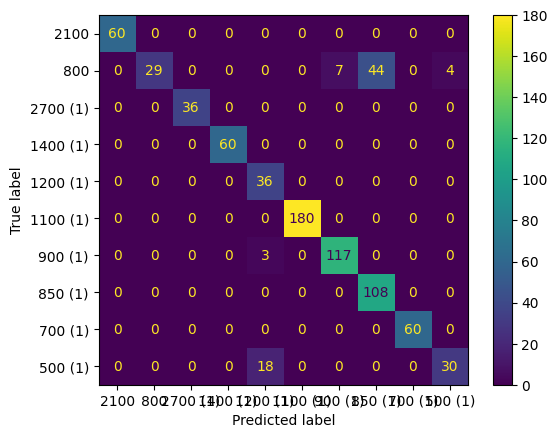

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(cm, class_names):
    fig, ax = plt.subplots()
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp = disp.plot(ax=ax)
    plt.show()


cm = confusion_matrix(y_true_classes, y_pred_classes)
plot_confusion_matrix(cm, class_names)

Text(0.5, 1.0, 'Precision-Recall Curve')

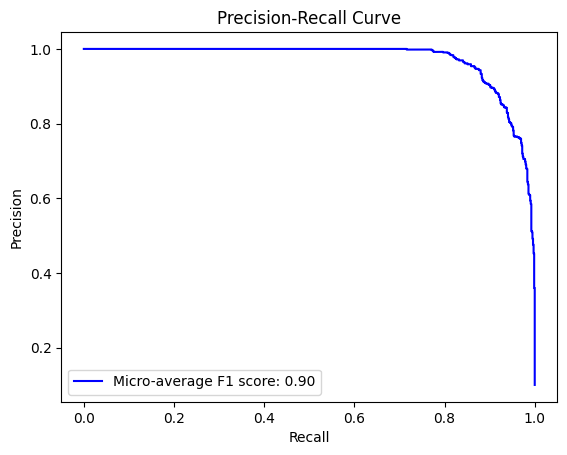

In [ ]:
precision, recall, _ = precision_recall_curve(y_test.ravel(), y_pred.ravel())
f1_score_micro = f1_score(y_true_classes, y_pred_classes, average='micro')
plt.plot(recall, precision, color='b', label=f'Micro-average F1 score: {f1_score_micro:0.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.title('Precision-Recall Curve')

Text(0.5, 1.0, 'ROC Curve')

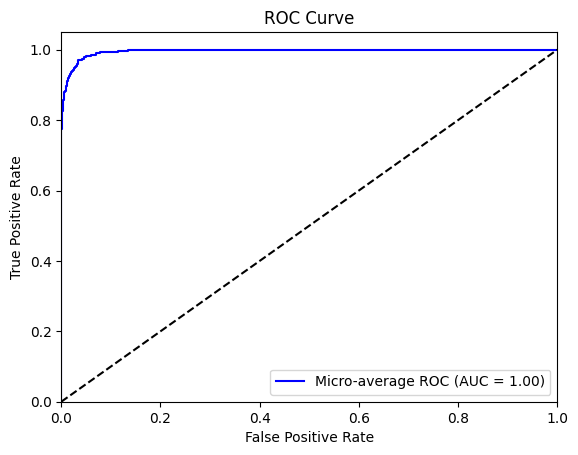

In [ ]:
fpr, tpr, _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc_micro = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='b', label=f'Micro-average ROC (AUC = {roc_auc_micro:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.title('ROC Curve')

Text(0.5, 1.0, 'ROC Curve')

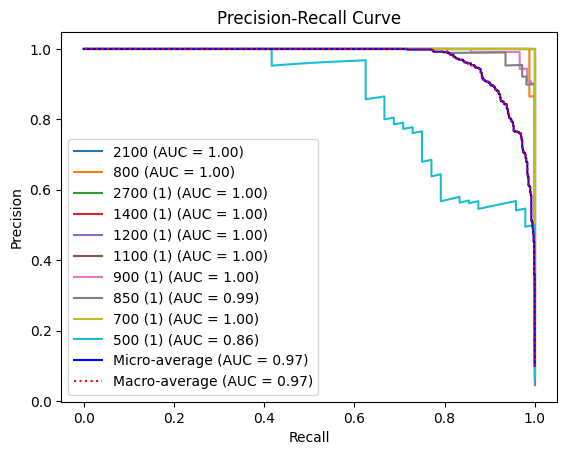

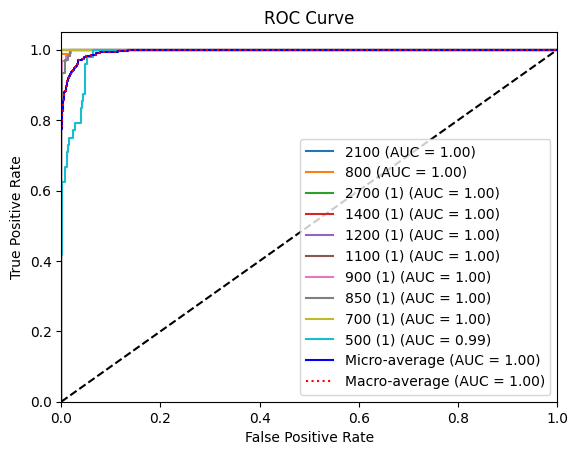

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import average_precision_score, roc_auc_score

# Binarize the labels
y_test_bin = label_binarize(y_test, classes=range(num_classes))

# Compute per-class precision-recall curve and ROC curve
precision = dict()
recall = dict()
fpr = dict()
tpr = dict()
for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_pred[:, i])
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])

# Compute macro-average precision-recall curve and ROC curve
precision["macro"], recall["macro"], _ = precision_recall_curve(y_test_bin.ravel(), y_pred.ravel())
fpr["macro"], tpr["macro"], _ = roc_curve(y_test_bin.ravel(), y_pred.ravel())

# Compute micro-average precision-recall curve and ROC curve
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_bin.ravel(), y_pred.ravel())
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred.ravel())

# Compute macro-average AUC and average precision
roc_auc_macro = roc_auc_score(y_test_bin, y_pred, average="macro", multi_class="ovr")
average_precision_macro = average_precision_score(y_test_bin, y_pred, average="macro")

# Plot per-class Precision-Recall and ROC curves
# Plot per-class Precision-Recall curves
plt.figure()
for i in range(num_classes):
    plt.plot(recall[i], precision[i], label=f'{class_names[i]} (AUC = {auc(recall[i], precision[i]):0.2f})')

plt.plot(recall['micro'], precision['micro'], color='b', label=f'Micro-average (AUC = {auc(recall["micro"], precision["micro"]):0.2f})')
plt.plot(recall['macro'], precision['macro'], color='r', linestyle=':', label=f'Macro-average (AUC = {auc(recall["macro"], precision["macro"]):0.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.title('Precision-Recall Curve')

# Plot per-class ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {auc(fpr[i], tpr[i]):0.2f})')

plt.plot(fpr['micro'], tpr['micro'], color='b', label=f'Micro-average (AUC = {roc_auc_micro:0.2f})')
plt.plot(fpr['macro'], tpr['macro'], color='r', linestyle=':', label=f'Macro-average (AUC = {roc_auc_macro:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.title('ROC Curve')



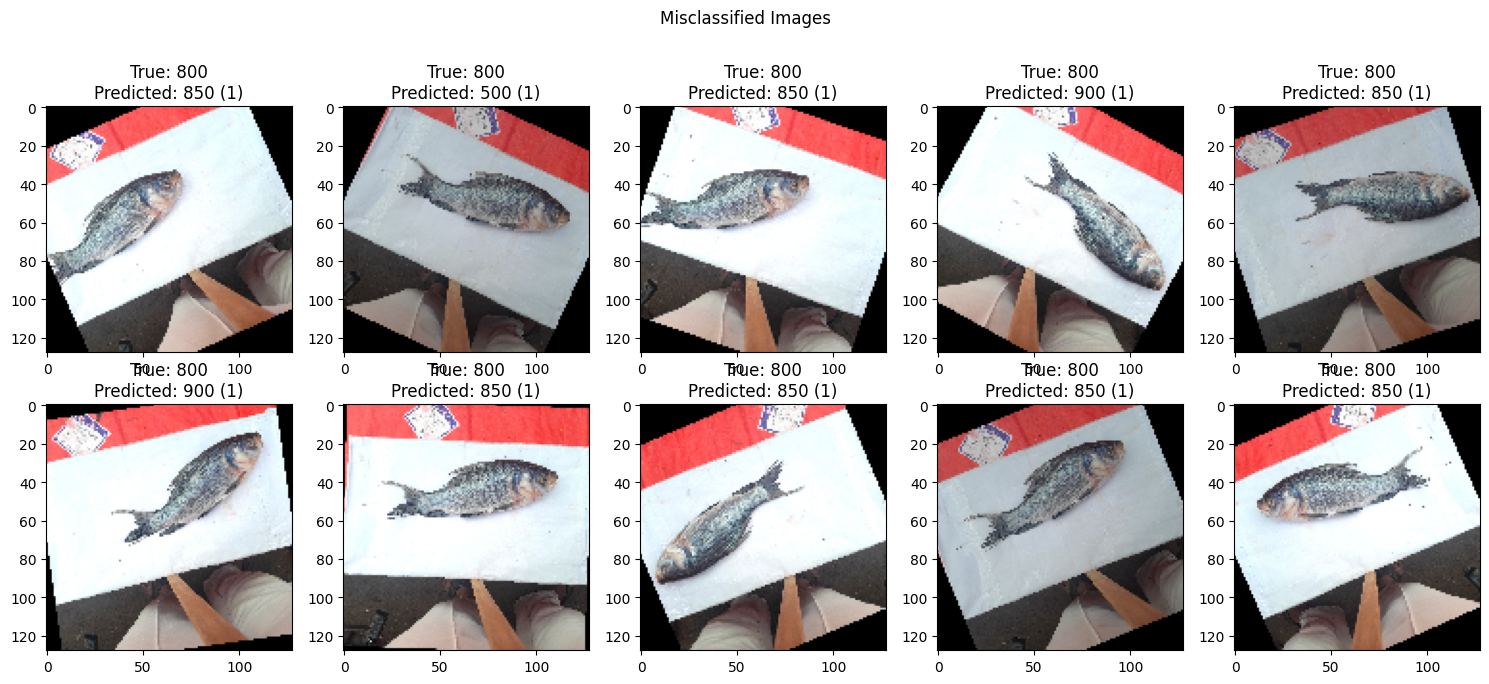

In [ ]:
errors = (y_pred_classes != y_true_classes)
y_pred_errors = y_pred[errors]
y_pred_classes_errors = y_pred_classes[errors]
y_true_classes_errors = y_true_classes[errors]
X_test_errors = X_test[errors]

def display_errors(images, true_labels, pred_labels, class_names, n_errors_to_show=5):
    n = 0
    nrows = 2
    ncols = n_errors_to_show // nrows
    fig, ax = plt.subplots(nrows, ncols, figsize=(15, 7))
    fig.suptitle('Misclassified Images')

    for i in range(nrows):
        for j in range(ncols):
            if n < n_errors_to_show:
                ax[i, j].imshow(cv2.cvtColor(images[n], cv2.COLOR_BGR2RGB))  # convert BGR to RGB
                true_label_str = class_names[true_labels[n]]
                pred_label_str = class_names[pred_labels[n]]
                ax[i, j].set_title(f'True: {true_label_str}\nPredicted: {pred_label_str}')
                n += 1
            else:
                break
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

display_errors(X_test_errors, y_true_classes_errors, y_pred_classes_errors, class_names, n_errors_to_show=10)
plt.show()

In [ ]:
import os
import numpy as np
import cv2
from google.colab import drive
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc, f1_score
import itertools
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/gdrive')

# Set dataset directory
dataset_dir = "/content/gdrive/MyDrive/Main"

# Set image size
img_size = 128

# Define batch size
batch_size = 16

# Load images and labels
images = []
labels = []
class_names = os.listdir(dataset_dir)
num_classes = len(class_names)
all = 0
for i, class_name in enumerate(class_names):
    t = 0
    print("Processing class {} ({}/{})".format(class_name, i+1, num_classes))
    class_dir = os.path.join(dataset_dir, class_name)
    for file_name in os.listdir(class_dir):
        t += 1
        all += 1
        img_path = os.path.join(class_dir, file_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (img_size, img_size))
        images.append(img)
        labels.append(i)
    print(class_name, t)
print(all)

# Convert to numpy arrays
images = np.array(images, dtype="float32")
labels = np.array(labels)

# Normalize pixel values to [0, 1]
images /= 255

# Convert labels to one-hot encoded vectors
labels = to_categorical(labels, num_classes=num_classes)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=42)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Processing class 2100 (1/10)
2100 300
Processing class 800 (2/10)
800 420
Processing class 500 (3/10)
500 240
Processing class 1100 (4/10)
1100 900
Processing class 2700 (5/10)
2700 180
Processing class 850 (6/10)
850 540
Processing class 1400 (7/10)
1400 300
Processing class 1200 (8/10)
1200 180
Processing class 900 (9/10)
900 600
Processing class 700 (10/10)
700 300
3960


In [ ]:
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50, DenseNet121
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from sklearn.metrics import average_precision_score, roc_auc_score


def build_and_train_pretrained_model(model_name):
    if model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
    elif model_name == 'GoogLeNet':
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
    elif model_name == 'ResNet':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
    elif model_name == 'DenseNet':
        base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

    # Add custom output layers for regression
    x = base_model.output
    x = Flatten()(x)
    x = Dense(2048, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.6)(x)
    x = Dense(2048, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.6)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Build the complete model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Create an instance of ImageDataGenerator with additional augmentations
    data_gen = ImageDataGenerator(width_shift_range=0.2,
                              height_shift_range=0.2,
                              fill_mode='nearest')

    # Calculate the number of steps per epoch
    steps_per_epoch = len(X_train) // batch_size

    # Define early stopping and learning rate reduction callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(data_gen.flow(X_train, y_train, batch_size=batch_size), steps_per_epoch=steps_per_epoch, validation_data=(X_test, y_test), epochs=50, callbacks=[early_stopping, reduce_lr])

    # Evaluate the model
    _, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"{model_name} Test accuracy: {accuracy * 100:.2f}%")

    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

    def plot_confusion_matrix(cm, class_names):
        fig, ax = plt.subplots()
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp = disp.plot(ax=ax)

    cm = confusion_matrix(y_true_classes, y_pred_classes)
    plot_confusion_matrix(cm, class_names)

    fpr, tpr, _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc_micro = auc(fpr, tpr)
    # plt.figure()
    # plt.plot(fpr, tpr, color='b', label=f'Micro-average ROC (AUC = {roc_auc_micro:0.2f})')
    # plt.plot([0, 1], [0, 1], 'k--')
    # plt.xlim([0.0, 1.0])
    # plt.ylim([0.0, 1.05])
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.legend(loc='best')
    # plt.title('ROC Curve')

    # Binarize the labels
    y_test_bin = label_binarize(y_test, classes=range(num_classes))

    # Compute per-class precision-recall curve and ROC curve
    precision = dict()
    recall = dict()
    fpr = dict()
    tpr = dict()
    for i in range(num_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_pred[:, i])
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])

    # Compute macro-average precision-recall curve and ROC curve
    precision["macro"], recall["macro"], _ = precision_recall_curve(y_test_bin.ravel(), y_pred.ravel())
    fpr["macro"], tpr["macro"], _ = roc_curve(y_test_bin.ravel(), y_pred.ravel())

    # Compute micro-average precision-recall curve and ROC curve
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_bin.ravel(), y_pred.ravel())
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred.ravel())

    # Compute macro-average AUC and average precision
    roc_auc_macro = roc_auc_score(y_test_bin, y_pred, average="macro", multi_class="ovr")
    average_precision_macro = average_precision_score(y_test_bin, y_pred, average="macro")

    # Plot per-class Precision-Recall and ROC curves
    # Plot per-class Precision-Recall curves
    plt.figure()
    for i in range(num_classes):
        plt.plot(recall[i], precision[i], label=f'{class_names[i]} (AUC = {auc(recall[i], precision[i]):0.2f})')

    plt.plot(recall['micro'], precision['micro'], color='b', label=f'Micro-average (AUC = {auc(recall["micro"], precision["micro"]):0.2f})')
    plt.plot(recall['macro'], precision['macro'], color='r', linestyle=':', label=f'Macro-average (AUC = {auc(recall["macro"], precision["macro"]):0.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='best')
    plt.title(f'Precision-Recall Curve - {model_name} ')

    # Plot per-class ROC curves
    plt.figure()
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {auc(fpr[i], tpr[i]):0.2f})')

    plt.plot(fpr['micro'], tpr['micro'], color='b', label=f'Micro-average (AUC = {roc_auc_micro:0.2f})')
    plt.plot(fpr['macro'], tpr['macro'], color='r', linestyle=':', label=f'Macro-average (AUC = {roc_auc_macro:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='best')
    plt.title(f'ROC Curve - {model_name}')

    plt.show()
    return model

VGG16
Epoch 1/50
198/198 [==============================] - 21s 98ms/step - loss: 5.9765 - accuracy: 0.3542 - val_loss: 4.2886 - val_accuracy: 0.7374 - lr: 1.0000e-04
Epoch 2/50
198/198 [==============================] - 16s 80ms/step - loss: 3.9964 - accuracy: 0.6938 - val_loss: 3.1528 - val_accuracy: 0.9470 - lr: 1.0000e-04
Epoch 3/50
198/198 [==============================] - 16s 79ms/step - loss: 3.2261 - accuracy: 0.8453 - val_loss: 2.7220 - val_accuracy: 0.9949 - lr: 1.0000e-04
Epoch 4/50
198/198 [==============================] - 16s 79ms/step - loss: 2.8200 - accuracy: 0.9031 - val_loss: 2.4581 - val_accuracy: 0.9987 - lr: 1.0000e-04
Epoch 5/50
198/198 [==============================] - 16s 79ms/step - loss: 2.5494 - accuracy: 0.9230 - val_loss: 2.2667 - val_accuracy: 0.9949 - lr: 1.0000e-04
Epoch 6/50
198/198 [==============================] - 16s 79ms/step - loss: 2.3264 - accuracy: 0.9422 - val_loss: 2.0958 - val_accuracy: 0.9987 - lr: 1.0000e-04
Epoch 7/50
198/198 [========

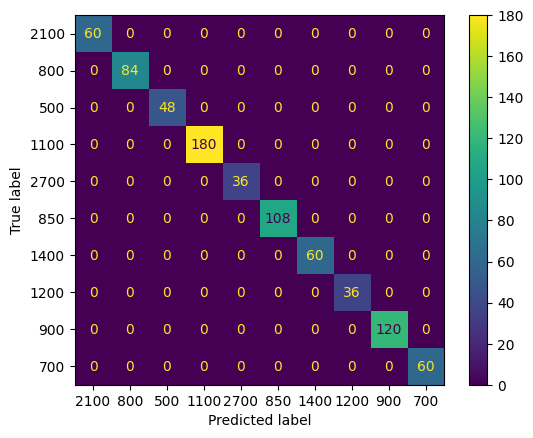

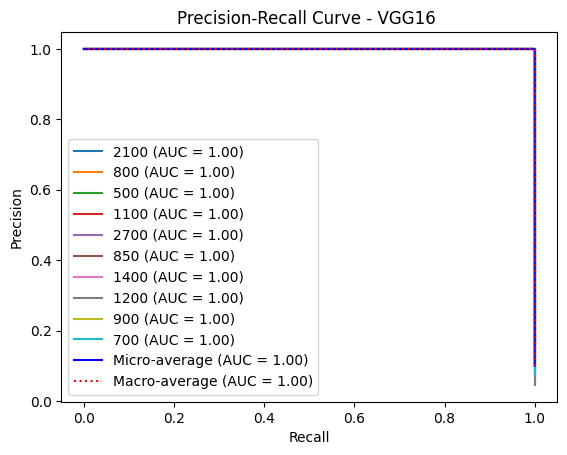

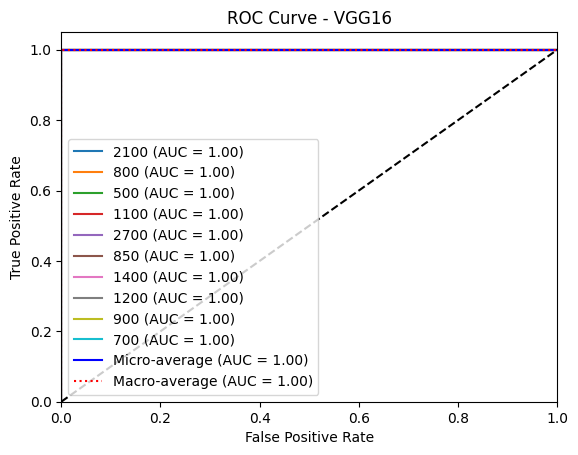

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
GoogLeNet
Epoch 1/50
198/198 [==============================] - 27s 111ms/step - loss: 8.4730 - accuracy: 0.3539 - val_loss: 5.6467 - val_accuracy: 0.7639 - lr: 1.0000e-04
Epoch 2/50
198/198 [==============================] - 16s 81ms/step - loss: 6.2823 - accuracy: 0.5379 - val_loss: 5.2869 - val_accuracy: 0.8409 - lr: 1.0000e-04
Epoch 3/50
198/198 [==============================] - 17s 84ms/step - loss: 5.8217 - accuracy: 0.6256 - val_loss: 5.0444 - val_accuracy: 0.8699 - lr: 1.0000e-04
Epoch 4/50
198/198 [==============================] - 19s 95ms/step - loss: 5.5029 - accuracy: 0.6673 - val_loss: 4.7743 - val_accuracy: 0.9192 - lr: 1.0000e-04
Epoch 5/50
198/198 [==============================] - 17s 84ms/step - loss: 5.2065 - accuracy: 0.7074 - val_loss: 4.5514 - val_accuracy: 0.9179 - lr: 1.00

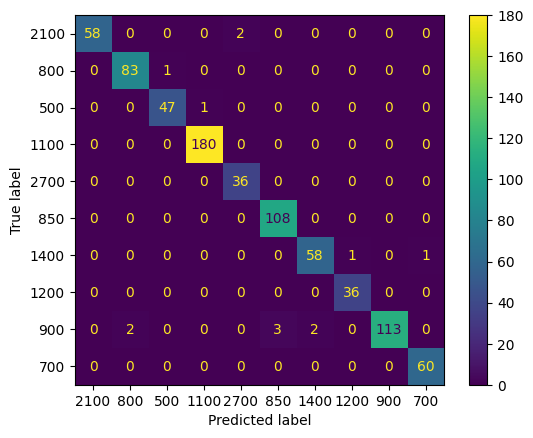

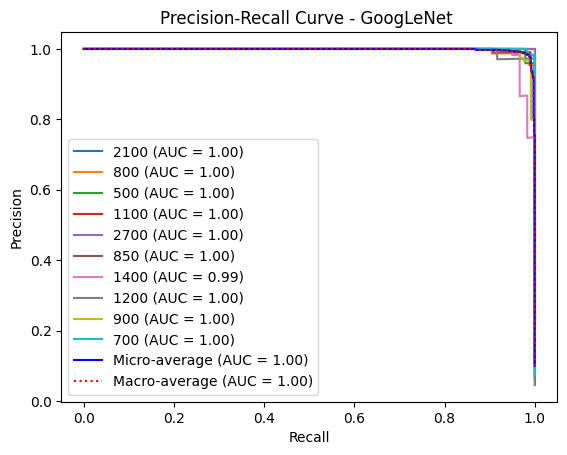

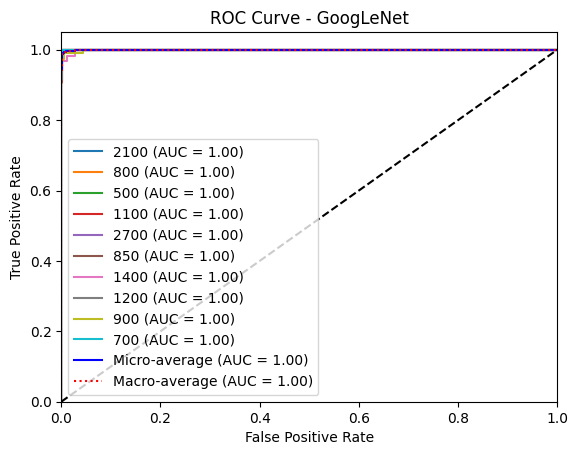

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
ResNet
Epoch 1/50
198/198 [==============================] - 24s 97ms/step - loss: 4.7694 - accuracy: 0.1856 - val_loss: 3.4322 - val_accuracy: 0.2386 - lr: 1.0000e-04
Epoch 2/50
198/198 [==============================] - 18s 90ms/step - loss: 3.3437 - accuracy: 0.2326 - val_loss: 3.1373 - val_accuracy: 0.2652 - lr: 1.0000e-04
Epoch 3/50
198/198 [==============================] - 18s 89ms/step - loss: 3.1307 - accuracy: 0.2462 - val_loss: 2.9983 - val_accuracy: 0.2753 - lr: 1.0000e-04
Epoch 4/50
198/198 [==============================] - 17s 86ms/step - loss: 2.9991 - accuracy: 0.2658 - val_loss: 2.8847 - val_accuracy: 0.2790 - lr: 1.0000e-04
Epoch 5/50
198/198 [==============================] - 17s 85ms/step - loss: 2.8908 - accuracy: 0.2866 - val_loss: 2.7822 - val_accuracy: 0.2689 - lr: 1.0000e-

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        2100       0.82      0.93      0.87        60
         800       0.43      0.29      0.34        84
         500       0.68      0.52      0.59        48
        1100       0.89      0.91      0.90       180
        2700       0.82      0.92      0.87        36
         850       0.69      0.88      0.78       108
        1400       0.82      0.62      0.70        60
        1200       0.00      0.00      0.00        36
         900       0.48      0.78      0.60       120
         700       0.65      0.33      0.44        60

    accuracy                           0.69       792
   macro avg       0.63      0.62      0.61       792
weighted avg       0.67      0.69      0.66       792



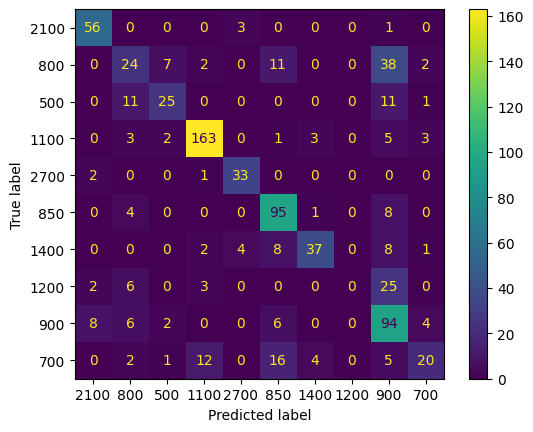

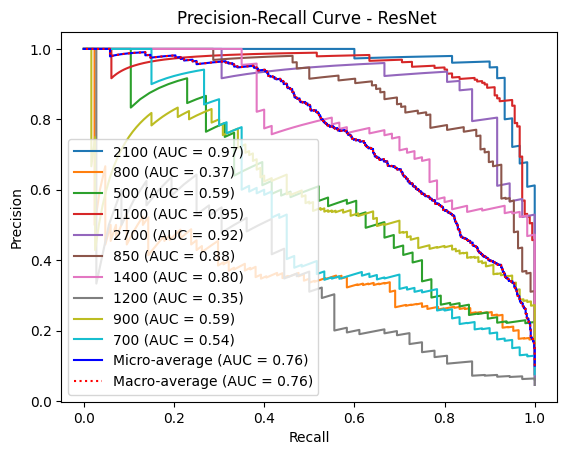

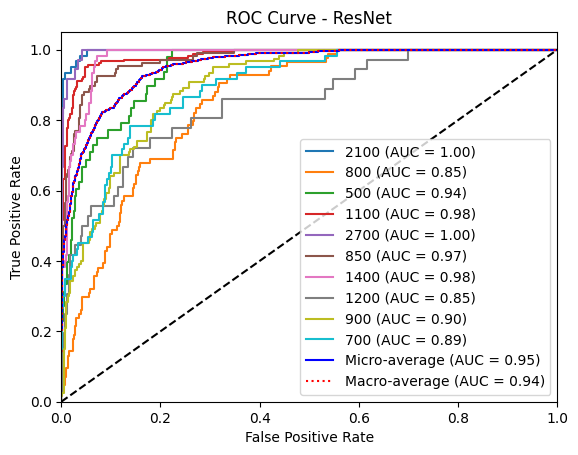

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
DenseNet
Epoch 1/50
198/198 [==============================] - 30s 117ms/step - loss: 7.2067 - accuracy: 0.4691 - val_loss: 4.2649 - val_accuracy: 0.8472 - lr: 1.0000e-04
Epoch 2/50
198/198 [==============================] - 17s 86ms/step - loss: 4.5117 - accuracy: 0.7323 - val_loss: 3.7145 - val_accuracy: 0.9167 - lr: 1.0000e-04
Epoch 3/50
198/198 [==============================] - 19s 95ms/step - loss: 3.9482 - accuracy: 0.8213 - val_loss: 3.4008 - val_accuracy: 0.9672 - lr: 1.0000e-04
Epoch 4/50
198/198 [==============================] - 18s 90ms/step - loss: 3.6124 - accuracy: 0.8681 - val_loss: 3.2001 - val_accuracy: 0.9823 - lr: 1.0000e-04
Epoch 5/50
198/198 [==============================] - 17s 86ms/step - loss: 3.4124 - accuracy: 0.8936 - val_loss: 3.0603 - val_accuracy: 0.9798 - lr: 1.000

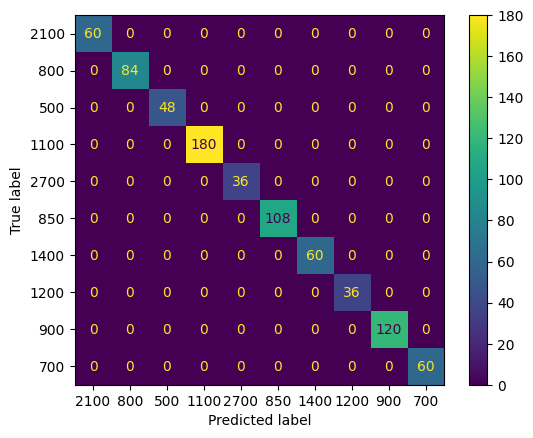

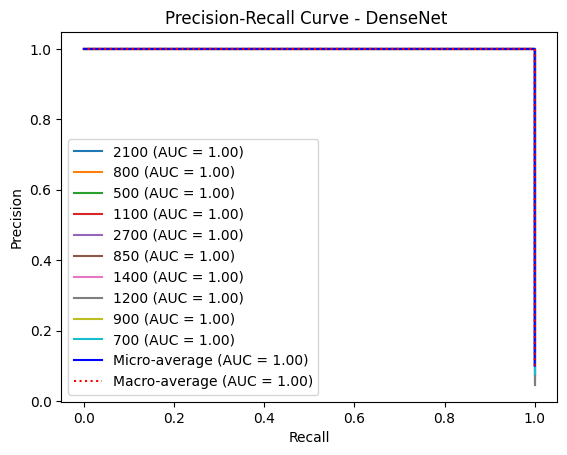

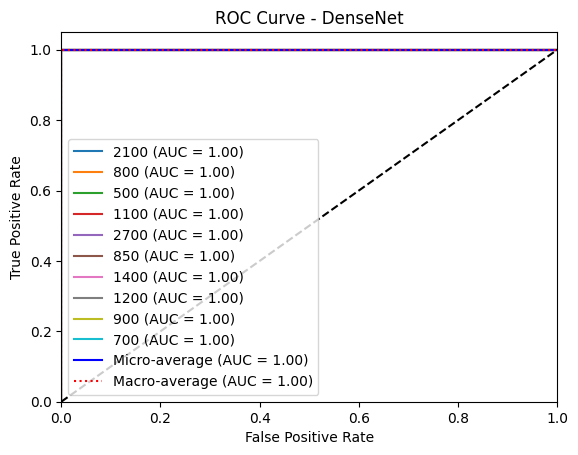

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
pretrained_models = ['VGG16', 'GoogLeNet', 'ResNet', 'DenseNet']
trained_models = {}

for model_name in pretrained_models:
    print(model_name)
    class_names = np.array(class_names)
    trained_model = build_and_train_pretrained_model(model_name)
    trained_models[model_name] = trained_model
    print('----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


### With Regression Model

In [ ]:
import os
import numpy as np
import cv2
from google.colab import drive
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc, f1_score
import itertools
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/gdrive')

# Set dataset directory
dataset_dir = "/content/gdrive/MyDrive/Main"

# Set image size
img_size = 128

# Define batch size
batch_size = 16

# Load images and labels
images = []
labels = []
class_names = os.listdir(dataset_dir)
num_classes = len(class_names)
all = 0
for i, class_name in enumerate(class_names):
    t = 0
    print("Processing class {} ({}/{})".format(class_name, i+1, num_classes))
    class_dir = os.path.join(dataset_dir, class_name)
    for file_name in os.listdir(class_dir):
        t += 1
        all += 1
        img_path = os.path.join(class_dir, file_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (img_size, img_size))
        images.append(img)
        labels.append(float(class_name))  # Change this line
    print(class_name, t)
print(all)

# Convert to numpy arrays
images = np.array(images, dtype="float32")
labels = np.array(labels)

# Normalize pixel values to [0, 1]
images /= 255

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Processing class 2100 (1/10)
2100 300
Processing class 800 (2/10)
800 420
Processing class 500 (3/10)
500 240
Processing class 1100 (4/10)
1100 900
Processing class 2700 (5/10)
2700 180
Processing class 850 (6/10)
850 540
Processing class 1400 (7/10)
1400 300
Processing class 1200 (8/10)
1200 180
Processing class 900 (9/10)
900 600
Processing class 700 (10/10)
700 300
3960


In [ ]:
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50, DenseNet121
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from sklearn.metrics import average_precision_score, roc_auc_score

def build_and_train_pretrained_model(model_name):
    if model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
    elif model_name == 'GoogLeNet':
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
    elif model_name == 'ResNet':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
    elif model_name == 'DenseNet':
        base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

    # Add custom output layers for regression
    x = base_model.output
    x = Flatten()(x)
    x = Dense(2048, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.6)(x)
    x = Dense(2048, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.6)(x)
    predictions = Dense(1, activation='linear')(x)

    # Build the complete model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Create an instance of ImageDataGenerator with additional augmentations
    data_gen = ImageDataGenerator(width_shift_range=0.2,
                              height_shift_range=0.2,
                              fill_mode='nearest')

    # Calculate the number of steps per epoch
    steps_per_epoch = len(X_train) // batch_size

    # Define early stopping and learning rate reduction callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['mean_absolute_error'])

    # Train the model
    model.fit(data_gen.flow(X_train, y_train, batch_size=batch_size), steps_per_epoch=steps_per_epoch, validation_data=(X_test, y_test), epochs=50, callbacks=[early_stopping, reduce_lr])

    # Evaluate the model
    _, mean_absolute_error = model.evaluate(X_test, y_test, verbose=0)
    print(f"{model_name} Test mean absolute error: {mean_absolute_error}")

    return model



#Pretrained Models Training

pretrained_models = ['VGG16', 'GoogLeNet', 'ResNet', 'DenseNet']
trained_models = {}

for model_name in pretrained_models:
    print(model_name)
    class_names = np.array(class_names)
    trained_model = build_and_train_pretrained_model(model_name)
    trained_models[model_name] = trained_model
    print('----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')

VGG16
Epoch 1/50
198/198 [==============================] - 19s 80ms/step - loss: 419999.0000 - mean_absolute_error: 462.9194 - val_loss: 182417.4531 - val_mean_absolute_error: 299.0469 - lr: 1.0000e-04
Epoch 2/50
198/198 [==============================] - 16s 78ms/step - loss: 135415.0469 - mean_absolute_error: 264.3244 - val_loss: 50364.5664 - val_mean_absolute_error: 163.1564 - lr: 1.0000e-04
Epoch 3/50
198/198 [==============================] - 15s 78ms/step - loss: 57438.4688 - mean_absolute_error: 179.9128 - val_loss: 28247.5449 - val_mean_absolute_error: 128.5560 - lr: 1.0000e-04
Epoch 4/50
198/198 [==============================] - 15s 77ms/step - loss: 42533.2461 - mean_absolute_error: 156.1253 - val_loss: 26470.8965 - val_mean_absolute_error: 127.5308 - lr: 1.0000e-04
Epoch 5/50
198/198 [==============================] - 15s 78ms/step - loss: 36085.0625 - mean_absolute_error: 143.5138 - val_loss: 24817.6895 - val_mean_absolute_error: 122.1578 - lr: 1.0000e-04
Epoch 6/50
198/1

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_regression_model(model, X_test, y_test):
    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return mse, mae, r2

# Evaluate each trained model
for model_name, model in trained_models.items():
    mse, mae, r2 = evaluate_regression_model(model, X_test, y_test)
    print(f"{model_name} Evaluation:")
    print(f"Mean squared error: {mse:.2f}")
    print(f"Mean absolute error: {mae:.2f}")
    print(f"R-squared value: {r2:.2f}")
    print('-------------------------------------')


25/25 [==============================] - 1s 41ms/step
VGG16 Evaluation:
Mean squared error: 6904.81
Mean absolute error: 65.00
R-squared value: 0.98
-------------------------------------
25/25 [==============================] - 2s 23ms/step
GoogLeNet Evaluation:
Mean squared error: 21323.18
Mean absolute error: 109.93
R-squared value: 0.92
-------------------------------------
25/25 [==============================] - 2s 33ms/step
ResNet Evaluation:
Mean squared error: 73327.69
Mean absolute error: 210.42
R-squared value: 0.74
-------------------------------------
25/25 [==============================] - 3s 35ms/step
DenseNet Evaluation:
Mean squared error: 8072.65
Mean absolute error: 67.23
R-squared value: 0.97
-------------------------------------
